In [2]:
pip install torch torchvision segmentation-models-pytorch opencv-python numpy matplotlib pillow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 142MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 276MB/s]


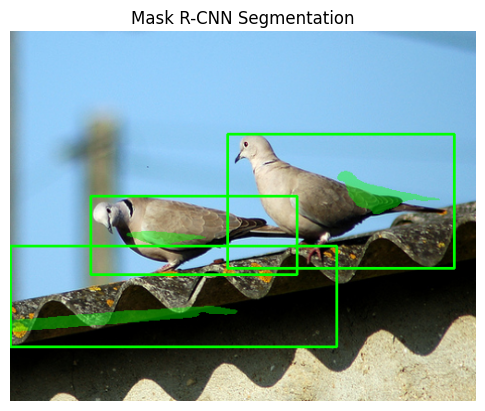

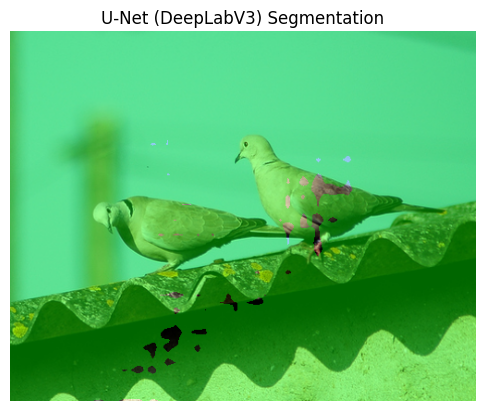

In [3]:
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
from segmentation_models_pytorch import DeepLabV3
from PIL import Image
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

mask_rcnn_model = models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)


# Load Pretrained Mask R-CNN Model

mask_rcnn_model.eval()

# Load Pretrained DeepLabV3 (U-Net Style) Model
unet_model = DeepLabV3(encoder_name="resnet50", encoder_weights="imagenet", classes=1, activation="sigmoid")
unet_model.eval()

def load_image(image_path):
    """Load image and preprocess it for PyTorch models"""
    img = Image.open(image_path).convert("RGB")

    # Ensure height and width are divisible by 8
    new_width = (img.width // 8 + 1) * 8 if img.width % 8 != 0 else img.width
    new_height = (img.height // 8 + 1) * 8 if img.height % 8 != 0 else img.height

    img = img.resize((new_width, new_height), Image.BILINEAR)

    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    return img, img_tensor


def run_mask_rcnn(image_path):
    """Run Mask R-CNN on an image using PyTorch"""
    img, img_tensor = load_image(image_path)

    # Run object detection
    with torch.no_grad():
        predictions = mask_rcnn_model(img_tensor)[0]  # Get first batch result

    img_np = np.array(img)
    if "masks" in predictions:
        for i in range(len(predictions["scores"])):
            score = predictions["scores"][i].item()
            if score > 0.5:
                box = predictions["boxes"][i].cpu().numpy().astype(int)
                x1, y1, x2, y2 = box
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Extract and overlay mask with transparency
                mask = predictions["masks"][i, 0].mul(255).byte().cpu().numpy()
                mask = cv2.resize(mask, (x2 - x1, y2 - y1))
                overlay = img_np[y1:y2, x1:x2].copy()
                overlay[mask > 128] = [0, 255, 0]
                img_np[y1:y2, x1:x2] = cv2.addWeighted(img_np[y1:y2, x1:x2], 0.6, overlay, 0.4, 0)

    # Show and save results
    plt.imshow(img_np)
    plt.title("Mask R-CNN Segmentation")
    plt.axis("off")
    plt.show()
    cv2.imwrite("mask_rcnn_pytorch_output.jpg", cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

def run_unet(image_path):
    """Run U-Net (DeepLabV3) segmentation using PyTorch"""
    img, img_tensor = load_image(image_path)

    # Run segmentation
    with torch.no_grad():
        mask = unet_model(img_tensor).squeeze(0).cpu().numpy()[0]  # Get first channel (binary mask)

    # Convert mask to binary and apply transparency
    mask = (mask > 0.5).astype(np.uint8) * 255
    img_np = np.array(img)
    overlay = img_np.copy()
    overlay[mask == 255] = [0, 255, 0]
    img_np = cv2.addWeighted(img_np, 0.6, overlay, 0.4, 0)

    # Show and save results
    plt.imshow(img_np)
    plt.title("U-Net (DeepLabV3) Segmentation")
    plt.axis("off")
    plt.show()
    cv2.imwrite("unet_pytorch_output.jpg", cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

# Provide image path
image_path = "//content//segmentation.jpg"

# Run both models
run_mask_rcnn(image_path)
run_unet(image_path)
